# 实作CycleGAN演算法
### 程式修改自[Cycle GAN with PyTorch](https://towardsdatascience.com/cycle-gan-with-pytorch-ebe5db947a99)

## 载入相关套件

In [2]:
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import ipywidgets
from IPython import display

In [29]:
!rm ./horse2zebra.zip

In [30]:
ls

sample_data/


## 上传资料集

In [31]:
from google.colab import files
files.upload()

Saving horse2zebra.zip to horse2zebra.zip


In [ ]:
# 直接使用gdown指令下载至虚拟机
!gdown https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

In [34]:
ls

horse2zebra/  horse2zebra.zip  sample_data/


## 解压缩，并重新命名目录，以利ImageFolder建立dataset

In [ ]:
!unzip ./horse2zebra.zip

In [44]:
import shutil, sys 
shutil.move("./horse2zebra/trainA", "./horses_train/A")
shutil.move("./horse2zebra/trainB", "./zebra_train/B")
shutil.move("./horse2zebra/testA", "./horses_test/A")
shutil.move("./horse2zebra/testB", "./zebra_test/B")

'./zebra_test/B'

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
ls ./horses_train

n02381460_1001.jpg  n02381460_2179.jpg  n02381460_394.jpg   n02381460_5857.jpg
n02381460_1002.jpg  n02381460_2181.jpg  n02381460_3956.jpg  n02381460_5864.jpg
n02381460_1003.jpg  n02381460_2192.jpg  n02381460_395.jpg   n02381460_5869.jpg
n02381460_1006.jpg  n02381460_2198.jpg  n02381460_3965.jpg  n02381460_5878.jpg
n02381460_1008.jpg  n02381460_2217.jpg  n02381460_396.jpg   n02381460_588.jpg
n02381460_1009.jpg  n02381460_2222.jpg  n02381460_3982.jpg  n02381460_5891.jpg
n02381460_1011.jpg  n02381460_2223.jpg  n02381460_3984.jpg  n02381460_5892.jpg
n02381460_1014.jpg  n02381460_2225.jpg  n02381460_3989.jpg  n02381460_58.jpg
n02381460_1019.jpg  n02381460_2226.jpg  n02381460_398.jpg   n02381460_5915.jpg
n02381460_1023.jpg  n02381460_222.jpg   n02381460_3995.jpg  n02381460_5917.jpg
n02381460_1025.jpg  n02381460_223.jpg   n02381460_3997.jpg  n02381460_591.jpg
n02381460_1027.jpg  n02381460_2245.jpg  n02381460_4008.jpg  n02381460_5927.jpg
n02381460_1028.jpg  n02381460_2259.jpg  n02381460_4009.j

## 建立 dataset、data loader

torch.Size([5, 3, 256, 256])


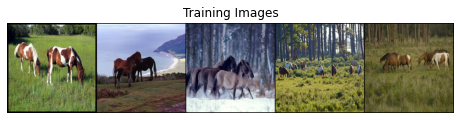

In [48]:
bs = 5
workers = 2
image_size = (256,256)
dataroot = './horses_train/'
dataset_horses_train = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_train_horses = torch.utils.data.DataLoader(dataset_horses_train, 
                        batch_size=bs, shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_train_horses))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], 
                             padding=2, normalize=True).cpu(),(1,2,0)))

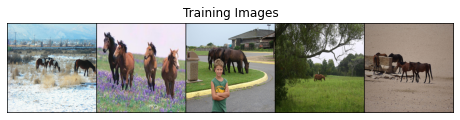

In [49]:
dataroot = './horses_test/'
dataset_horses_test = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_test_horses = torch.utils.data.DataLoader(dataset_horses_test, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_test_horses))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

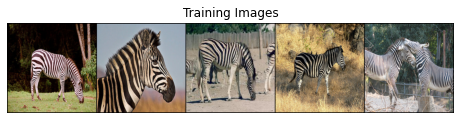

In [50]:
dataroot = './zebra_train'
dataset_zebra_train = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_zebra_train = torch.utils.data.DataLoader(dataset_zebra_train, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_zebra_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

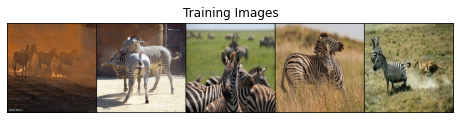

In [51]:
dataroot = './zebra_test'
dataset_zebra_test = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_zebra_test = torch.utils.data.DataLoader(dataset_zebra_test, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_zebra_test))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

## 定义绘制4个影像的函数：真实的马、生成的斑马、真实的斑马、生成的马

In [52]:
def plot_images_test(dataloader_test_horses, dataloader_zebra_test): 
    batch_a_test = next(iter(dataloader_test_horses))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    # 将马变成斑马
    fake_b_test = G_A2B(batch_a_test ).cpu().detach()

    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:4]+1)/2,
                         padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real horses")
    plt.show()
          
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:4]+1)/2, 
                         padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake zebras")
    plt.show()

    batch_b_test = next(iter(dataloader_zebra_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    # 将斑马变成马
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:4]+1)/2, 
                         padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real zebras")
    plt.show()

    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:4]+1)/2, 
                         padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake horses")
    plt.show()

## 定义绘制8个影像的函数

In [53]:
def plot_all_images(image_number, dataloader_test_horses, dataloader_zebra_test): 
    #generate fake zebras
    batch_a_test = next(iter(dataloader_test_horses))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real horses")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake zebras")
    plt.show()
    #generate fake horses
    batch_b_test = next(iter(dataloader_zebra_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real zebras")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake horses")
    plt.show()
    #identity 
    identity_a_test=G_B2A(batch_a_test.cuda() ).cpu().detach()
    identity_b_test=G_A2B(batch_b_test.cuda() ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((identity_a_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Identity horses")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((identity_b_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Identity zebras")
    plt.show()
    #recovered image
    recover_a_test=G_B2A(fake_b_test.cuda()  ).cpu().detach()
    recover_b_test=G_A2B(fake_a_test.cuda()  ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_a_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered horses")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_b_test[:image_number]+1)/2, 
                                     padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered zebras")
    plt.show()

## 定义模型存档与载入的函数

In [54]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):
    torch.save(G_A2B, "/content/gdrive/My Drive/model_proj3/"+name+"_G_A2B.pt")
    torch.save(G_B2A, "/content/gdrive/My Drive/model_proj3/"+name+"_G_B2A.pt")
    torch.save(D_A, "/content/gdrive/My Drive/model_proj3/"+name+"_D_A.pt")
    torch.save(D_B, "/content/gdrive/My Drive/model_proj3/"+name+"_D_B.pt")

def load_models(name):
    G_A2B=torch.load("/content/gdrive/My Drive/model_proj3/"+name+"_G_A2B.pt")
    G_B2A=torch.load("/content/gdrive/My Drive/model_proj3/"+name+"_G_B2A.pt")
    D_A=torch.load("/content/gdrive/My Drive/model_proj3/"+name+"_D_A.pt")
    D_B=torch.load("/content/gdrive/My Drive/model_proj3/"+name+"_D_B.pt")
    return G_A2B, G_B2A, D_A, D_B

#save_models(G_A2B, G_B2A, D_A, D_B, "test")
#G_A2B, G_B2A, D_A, D_B= load_models("test")

## 定义生成网路训练函数

In [55]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), 
                                            norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), 
                                            norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

## 定义判别网路训练函数

In [56]:
nc=3
ndf=64
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc,ndf,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf,ndf*2,4,2,1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4,ndf*8,4,1,1),
            nn.InstanceNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 15 x 15
            nn.Conv2d(ndf*8,1,4,1,1)
            # state size. 1 x 14 x 14
        )

    def forward(self, input):
        return self.main(input)

## 定义判别网路及生成网路的损失函数

In [57]:
def LSGAN_D(real, fake):
    return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
    return  torch.mean((fake - 1)**2)

## 建立判别及生成网路

In [62]:
import itertools

G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Initialize Loss function
criterion_Im = torch.nn.L1Loss() 

# Learning rate for optimizers
lr = 0.0002

# Optimizers
# optimizer_G = torch.optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()),
#                                lr=lr, betas=(0.5, 0.999))
optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

## 定义训练模型的函数

In [63]:
def training(G_A2B, G_B2A, D_A, D_B,num_epochs,name,old = True):
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_A_losses = []
    D_B_losses = []


    iters=0
    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_A = []
    disc_B = []


    FDL_A2B_t = []
    FDL_B2A_t = []
    CL_A_t = []
    CL_B_t = []
    ID_B2A_t = []
    ID_A2B_t = []
    disc_A_t = []
    disc_B_t = []

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for  i,(data_horse, data_zebra) in enumerate(zip(dataloader_train_horses, dataloader_zebra_train),0):
    
            # Set model input
            a_real = data_horse[0].to(device)
            b_real = data_zebra[0].to(device)

            tensor_ones=torch.ones([a_real.shape[0],1,14,14]).cuda()
            tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).cuda()

            # Genrated images
            b_fake = G_A2B(a_real)
            a_rec = G_B2A(b_fake)
            a_fake = G_B2A(b_real)
            b_rec = G_A2B(a_fake)


            # Discriminator A
            optimizer_D_A.zero_grad()
            if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
                rand_int = random.randint(5, old_a_fake.shape[0]-1)
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-5:rand_int].detach()))
                D_A_losses.append(Disc_loss_A.item())
            else:
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
                D_A_losses.append(Disc_loss_A.item())
        
            Disc_loss_A.backward()
            optimizer_D_A.step()

        
            # Discriminator B
            optimizer_D_B.zero_grad()
            if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
                rand_int = random.randint(5, old_b_fake.shape[0]-1)
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-5:rand_int].detach()))
                D_B_losses.append(Disc_loss_B.item())
            else:
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
                D_B_losses.append(Disc_loss_B.item())

            Disc_loss_B.backward()
            optimizer_D_B.step()   

            # Generator
            optimizer_G_A2B.zero_grad()
            optimizer_G_B2A.zero_grad()

            # Fool discriminator
            Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
            Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

            # Cycle Consistency    both use the two generators
            Cycle_loss_A = criterion_Im(a_rec, a_real)*5
            Cycle_loss_B = criterion_Im(b_rec, b_real)*5

            # Identity loss
            Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
            Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

            # generator losses
            Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
            G_losses.append(Loss_G)

            # Backward propagation
            Loss_G.backward()


            # Optimisation step
            optimizer_G_A2B.step()
            optimizer_G_B2A.step()

            FDL_A2B.append(Fool_disc_loss_A2B)
            FDL_B2A.append(Fool_disc_loss_B2A)
            CL_A.append(Cycle_loss_A)
            CL_B.append(Cycle_loss_B)
            ID_B2A.append(Id_loss_B2A)
            ID_A2B.append(Id_loss_A2B)
            disc_A.append(Disc_loss_A)
            disc_B.append(Disc_loss_B)

            if(iters == 0 and epoch == 0):
                old_b_fake = b_fake.clone()
                old_a_fake = a_fake.clone()
            elif (old_b_fake.shape[0] == bs*5 and b_fake.shape[0]==bs):
                rand_int = random.randint(5, 24)
                old_b_fake[rand_int-5:rand_int] = b_fake.clone()
                old_a_fake[rand_int-5:rand_int] = a_fake.clone()
            elif(old_b_fake.shape[0]< 25):
                old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
                old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

            iters += 1
            del data_zebra, data_horse, a_real, b_real, a_fake, b_fake


            if iters % 50 == 0:   
                print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                          Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
        

    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))

    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_B = []
    disc_A = []

    iters = 0             
    save_models(G_A2B, G_B2A, D_A, D_B, name)
    if (epoch % 5 == 0):
        plot_images_test(dataloader_test_horses, dataloader_zebra_test)
    #plot_all_images(4, dataloader_test_horses, dataloader_zebra_test)
    return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)

In [ ]:
name = 'basic_training50'
epochs=20
losses = training(G_A2B, G_B2A, D_A, D_B, epochs, name)

Starting Training Loop...
[1/20]	FDL_A2B: 0.3813	FDL_B2A: 0.2695	CL_A: 0.7056	CL_B: 0.8052	ID_B2A: 1.2255	ID_A2B: 1.3913	Loss_D_A: 0.5170	Loss_D_A: 0.4950
[1/20]	FDL_A2B: 0.2173	FDL_B2A: 0.2991	CL_A: 0.8329	CL_B: 0.7392	ID_B2A: 1.6169	ID_A2B: 1.1119	Loss_D_A: 0.4695	Loss_D_A: 0.4752
[1/20]	FDL_A2B: 0.3008	FDL_B2A: 0.2978	CL_A: 0.5260	CL_B: 0.7110	ID_B2A: 1.0279	ID_A2B: 1.3604	Loss_D_A: 0.4565	Loss_D_A: 0.5196
[1/20]	FDL_A2B: 0.3113	FDL_B2A: 0.4006	CL_A: 0.5929	CL_B: 0.7147	ID_B2A: 0.9955	ID_A2B: 1.2579	Loss_D_A: 0.6762	Loss_D_A: 0.4603
[2/20]	FDL_A2B: 0.3400	FDL_B2A: 0.2353	CL_A: 0.4916	CL_B: 0.6303	ID_B2A: 0.9344	ID_A2B: 1.1136	Loss_D_A: 0.4964	Loss_D_A: 0.4420
[2/20]	FDL_A2B: 0.3491	FDL_B2A: 0.3915	CL_A: 0.4052	CL_B: 0.5667	ID_B2A: 0.8246	ID_A2B: 0.9742	Loss_D_A: 0.4936	Loss_D_A: 0.4154
[2/20]	FDL_A2B: 0.3188	FDL_B2A: 0.3276	CL_A: 0.5541	CL_B: 0.5319	ID_B2A: 0.9651	ID_A2B: 0.9507	Loss_D_A: 0.5565	Loss_D_A: 0.5333
[2/20]	FDL_A2B: 0.2343	FDL_B2A: 0.3111	CL_A: 0.6222	CL_B: 0.8700	ID_B2A

## 存档

In [ ]:
if not os.path.exists('./CycleGAN'):
    os.makedirs('./CycleGAN')
# save last check pointing
torch.save(G_A2B.state_dict(), f"./CycleGAN/netG_A2B.pth")
torch.save(G_B2A.state_dict(), f"./CycleGAN/netG_B2A.pth")
torch.save(D_A.state_dict(), f"./CycleGAN/netD_A.pth")
torch.save(D_B.state_dict(), f"./CycleGAN/netD_B.pth")

In [ ]:
# 压缩相关模型
!zip ./model.zip ./CycleGAN/*.*

In [ ]:
from google.colab import files
files.download('./model.zip')